#Smooth Data

In [45]:
import pandas as pd

file_path = "./Physionet_ECGs/sel_100_tabsep.csv"
data = pd.read_csv(file_path, sep = '\t', index_col= 0, header=None)
data.head()

,1,2
0,,
0.000,4.725,4.775
0.004,4.735,4.745
0.008,4.725,4.735
0.012,4.715,4.745
0.016,4.720,4.735


Select the column you want to smooth

In [110]:
import numpy as np
import matplotlib.pyplot as plt
col = 2 #choose 1 or 2
values = data[col].values
times = data[col].index

Float64Index([    0.0,   0.004,   0.008,   0.012,   0.016,    0.02,   0.024,
                0.028,   0.032,   0.036, 
              ...
               899.96, 899.964, 899.968, 899.972, 899.976,  899.98, 899.984,
              899.988, 899.992, 899.996],
             dtype='float64', name=0, length=225000)

##Smooth Data With Fast Fourier Transform

Fast Fourier Transform and plot the data

In [95]:
from numpy import fft
signal = np.array(values)
transformed = fft.fft(signal)
real = transformed.real
plt.plot(range(len(real)),real)
plt.ylim(1000,-1000)
plt.show()

In [117]:
ps = np.abs(transformed)**2
timestep = times[1]-times[0]
freqs = np.fft.fftfreq(signal.size,timestep)
idx = np.argsort(freqs)
print ps
plt.plot(freqs[idx], ps[idx])
#plt.plot(freqs, real)
plt.show()

[  1.23266034e+12   3.77145727e+06   2.14703001e+06 ...,   2.09865291e+06
   2.14703001e+06   3.77145727e+06]


In [135]:
#from glowing-python: http://glowingpython.blogspot.com/2011/08/how-to-plot-frequency-spectrum-with.html
from numpy import sin, linspace, pi
from pylab import plot, show, title, xlabel, ylabel, subplot
from scipy import fft, arange

def plotSpectrum(y,Fs=None):
    """
    Plots a Single-Sided Amplitude Spectrum of y(t)
    calcs the sampling rate from the first two elements of the array.
    """
    
    Fs = Fs or 1/(signal[1]-signal[0]) #sampling rate
    n = int(len(y)) # length of the signal
    print n
    k = arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(int(n/2))] # one side frequency range

    Y = fft(y)/n # fft computing and normalization
    Y = Y[range(int(n/2))]

    plot(frq,abs(Y),'r') # plotting the spectrum
    xlabel('Freq (Hz)')
    ylabel('|Y(freq)|')

#subplot(2,1,1)
#plot(times,signal)
#xlabel('Time')
#ylabel('Amplitude')
plotSpectrum(signal[0:1000],Fs)
plt.ylim(0,.03)
show()

1000


Mask the noise in the FFT'ed data and plot the signal with the mask

In [58]:
def mask_fft(transformed, masks=[(54000,171000)], ylims=(1000,-1000)):
    '''
    The default settings work well for column 1
    '''
    masked = transformed
    for i in masks:
        mask_min = i[0]
        mask_max = i[1]
        masked[mask_min:mask_max] = 0 + 0j
    real2 = transformed.real
    plt.plot(range(len(real2)),real2)
    plt.ylim(*ylims)
    return masked
masked = mask_fft(transformed, [(40000,190000)])
plt.gca()
plt.show()

reverse FFT the signal and plot the smoothed data

In [55]:
ifft = fft.ifft(transformed)
plt.plot(times, ifft.real, "r", label = 'transformed')
plt.plot(times, signal, 'b', label="original")
plt.legend()
plt.xlim(0,1000)
plt.show()

Save!

##Working in R

In [6]:
%load_ext rmagic  

/Users/morganfine-morris/anaconda/lib/python2.7/site-packages/IPython/extensions/rmagic.py:693: UserWarning: The rmagic extension in IPython is deprecated in favour of rpy2.ipython. If available, that will be loaded instead.
http://rpy.sourceforge.net/
  warnings.warn("The rmagic extension in IPython is deprecated in favour of "


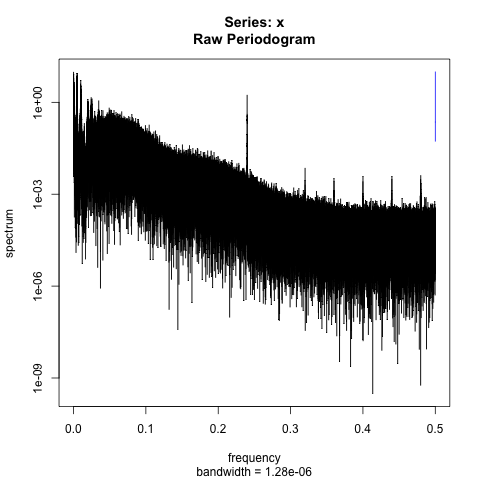

In [70]:
%%R -i values -o values_spect
values_spect = spectrum(values)

#print(summary(values_spect))


In [94]:
print values_spect.names
for i in values_spect.items():
    print i
    print

 [1] "freq"      "spec"      "coh"       "phase"     "kernel"    "df"       
 [7] "bandwidth" "n.used"    "orig.n"    "series"    "snames"    "method"   
[13] "taper"     "pad"       "detrend"   "demean"   

('freq', <FloatVector - Python:0x1146cdcf8 / R:0x114249000>
[0.000004, 0.000009, 0.000013, ..., 0.499991, 0.499996, 0.500000])

('spec', <FloatVector - Python:0x1146cd320 / R:0x115245000>
[3.928853, 1.672682, 1.579693, ..., 0.000074, 0.000108, 0.000003])

('coh', rpy2.rinterface.NULL)

('phase', rpy2.rinterface.NULL)

('kernel', rpy2.rinterface.NULL)

('df', <FloatVector - Python:0x1146cd758 / R:0x113928d08>
[1.791590])

('bandwidth', <FloatVector - Python:0x1146cdc68 / R:0x113928cd8>
[0.000001])

('n.used', <IntVector - Python:0x1146cdd40 / R:0x113c968b8>
[  225000])

('orig.n', <IntVector - Python:0x108de4878 / R:0x113906e58>
[  225000])

('series', <StrVector - Python:0x108de45f0 / R:0x11390a628>
[str])

('snames', rpy2.rinterface.NULL)

('method', <StrVector - Python:0x108de4fc

###Savitzky-Golay

In [38]:
values = ifft

In [39]:
%%R -i values -o sg_smoothed
sg5 = c(-3, 12, 17, 12, -3)/35
sg_smoothed = filter(values,sg5)

In [40]:
df_sg = pd.DataFrame(data = np.array(sg_smoothed), index = times, columns=[col]).dropna()
plt.plot(df_sg.index, df_sg.values, lw=2)
plt.plot(times, values, 'r', lw=1)
#plt.plot(times,ifft.real,"g", lw=1)
plt.show()

/Users/morganfine-morris/anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:462: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


##Moving Average

In [41]:
%%R -i values -o smoothed
ma5 = c(1, 1, 1, 1, 1)/5;
smoothed =filter(values,ma5)
print(smoothed[0:100])

  [1]       NA       NA 4.755170 4.735266 4.728668 4.725531 4.720334 4.713546
  [9] 4.707950 4.704606 4.702447 4.700526 4.699285 4.699606 4.701676 4.705418
 [17] 4.711531 4.721254 4.734957 4.751331 4.768145 4.783608 4.797020 4.808519
 [25] 4.818550 4.827453 4.835248 4.841739 4.846934 4.851298 4.855391 4.859189
 [33] 4.861916 4.862654 4.861105 4.857816 4.853961 4.851015 4.850307 4.852278
 [41] 4.855917 4.859127 4.860060 4.858335 4.855105 4.852009 4.850026 4.849107
 [49] 4.848616 4.848044 4.847371 4.846828 4.846323 4.845224 4.842856 4.839267
 [57] 4.835363 4.832152 4.829865 4.827860 4.825327 4.822015 4.818392 4.815303
 [65] 4.813471 4.813099 4.813739 4.814554 4.814819 4.814253 4.812997 4.811458
 [73] 4.810245 4.809968 4.810736 4.811838 4.812257 4.811685 4.810891 4.810909
 [81] 4.811982 4.813459 4.814537 4.814773 4.813980 4.812149 4.809764 4.807836
 [89] 4.807157 4.807560 4.808241 4.808813 4.809689 4.811388 4.813901 4.817053
 [97] 4.821143 4.826710 4.833617 4.840720


In [44]:
df = pd.DataFrame(data = np.array(smoothed), index = times, columns=[col])
df_clean = df.dropna()
plt.plot(df_clean.index, df_clean.values, lw=3, label="ifft MA Smoothed")
plt.plot(times, values, 'r', lw=2, label="original")
plt.plot(times,ifft.real,"g", lw=1, label="ifft")
plt.legend()
plt.show()

In [9]:
len(df_clean.values), len(df_clean.index)

(224996, 224996)

In [10]:
df_clean.to_csv('./Physionet_ECGs/sel_100_tabsep_mvsmooth.csv', header=False, sep="\t")

In [ ]:
def calc_slopes(X, Y):
    dY = (np.roll(Y, -1, axis=1) - Y)[:-1]
    dX = (np.roll(X, -1, axis=0) - X)[:-1]

    slopes = dY/dX
    return slopes
    
calc_slopes(df_clean.index, df_clean.values)

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import RadioButtons

t = np.arange(0.0, 2.0, 0.01)
s0 = np.sin(2*np.pi*t)
s1 = np.sin(4*np.pi*t)
s2 = np.sin(8*np.pi*t)

fig, ax = plt.subplots()
l, = ax.plot(t, s0, lw=2, color='red')
plt.subplots_adjust(left=0.3)

axcolor = 'lightgoldenrodyellow'
rax = plt.axes([0.05, 0.7, 0.15, 0.15], axisbg=axcolor)
radio = RadioButtons(rax, ('2 Hz', '4 Hz', '8 Hz'))
def hzfunc(label):
    hzdict = {'2 Hz':s0, '4 Hz':s1, '8 Hz':s2}
    ydata = hzdict[label]
    l.set_ydata(ydata)
    plt.draw()
radio.on_clicked(hzfunc)

rax = plt.axes([0.05, 0.4, 0.15, 0.15], axisbg=axcolor)
radio2 = RadioButtons(rax, ('red', 'blue', 'green'))
def colorfunc(label):
    l.set_color(label)
    plt.draw()
radio2.on_clicked(colorfunc)

rax = plt.axes([0.05, 0.1, 0.15, 0.15], axisbg=axcolor)
radio3 = RadioButtons(rax, ('-', '--', '-.', 'steps', ':'))
def stylefunc(label):
    l.set_linestyle(label)
    plt.draw()
radio3.on_clicked(stylefunc)

plt.show()